# CSC424 - Machine Learning - Assignment 2

<br>

### Team - Random Access Memories
> #### Rivu Bhattacharjee — 1910626
> #### Ahnaf Abdullah — 2130223
> #### Tausia Tahsin Nuzum — 2221415



## Problems

#### Assignment 2A

1.	Perform assignment 1B with pytorch

  * Write `forward(X)` function to implement the forward calculation.
  * Use the forward function to pass the input data to calculate the probabilities.
  * Calculate the loss using criterion function with cross entropy option.
  * Using the loss, use `autograd` and `backward()` to calculate the derivatives automatically.
  * Write codes for a training module for 100 epochs to train the neural network.

#### Assignment 2B (same as 2a and use pytorch)

You need to design the two layer neural network shown in the following figure

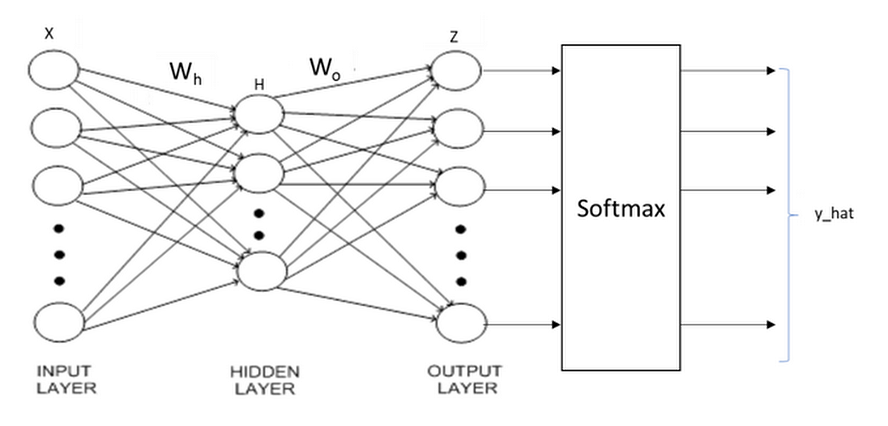

* So, output probability:

$$\hat{y} = \texttt{softmax}(HW_o + b_o)$$

Where $H = xW_h + b_h$, $\hat{y}$ is the output vector of size 10.

* $x$ is input vector of size 1x784, $W_h$ are weight matrix for hidden layer. $W_o$ is the weight matrix for output layer. $b_h$ and $b_o$ are bias vectors for corresponding layers.

* In the hidden layer, you will have only 3 neurons as shown in the following image. So $H$ has length 3 for each input.

* Therefore: The size of the $W_h$ will be 784x3 and $W_o$ size will be 3x10

* Use the cross entropy as your loss function.

* Write codes for a training module for $100$ epochs to train the above neural network with batch size $2048$ and learning rate $0.001$.

* Show your training and validation loss plot

* Report your F1 scores on the test set

* Show confusion matrix of your test prediction

*	Now, take $H$ vectors (3D points) for all test images, plot them in the 3D space. Choose the marker shape for each ground truth class and choose the color of marker-based on the predicted class.

*	Therefore, if different colored points with same shape or different shaped points with same color are the classification errors.


#### Assignment 2C  *(Bonus 100)*
* Implement and complete the Assignment 2B without any pytorch library
*	Calculate the derivative with hand in pen and paper
*	Write codes for forward and back propagation using the derived equation.


## Setup



### Imports and Defines

In [ ]:
import os         # file en
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

import tqdm
import yaml
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split

from urllib import request  # HTTP downloading, download_and_load_dataset
import gzip     # extract tarballs

from google.colab import files   # download file programatically when done
import pickle
#from dataclasses import dataclass, field

### Helper Functions



In [ ]:
def download_and_load_dataset(write_to_file=False, BASE_URL="http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"):
    """Downloads the dataset pointed to by BASE_URL (should point to a MNIST-like dataset
    following all naming conventions) and returns 4 sets of training images, training labels, testing images and testing labels"""

    filename = [
        ["training_images","train-images-idx3-ubyte.gz"],
        ["test_images","t10k-images-idx3-ubyte.gz"],
        ["training_labels","train-labels-idx1-ubyte.gz"],
        ["test_labels","t10k-labels-idx1-ubyte.gz"]
        ]

    if write_to_file:
        import pickle

    def download_mnist():
        for name in filename:
            if not os.path.isfile(name[1]):
                print("Downloading "+name[1]+"...")
                request.urlretrieve(BASE_URL+name[1], name[1])
            else:
                print("File " + name[1] + " already downloaded")
        print("Download complete.")

    def save_mnist():
        mnist = {}
        for name in filename[:2]:
            with gzip.open(name[1], 'rb') as f:
                mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
        for name in filename[-2:]:
            with gzip.open(name[1], 'rb') as f:
                mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
        if write_to_file:
            with open("mnist.pkl", 'wb') as f:
                pickle.dump(mnist,f)
            print("Save complete.")
        return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]


    download_mnist()
    return save_mnist()


In [ ]:
def show_image(img_arr: np.array, shape=(28, 28), label=None, boxborder=True):
    """A highly customizable plotter function that renders a single greyscale image. """
    plt.figure(figsize=(2, 2))
    #
    if boxborder:
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      plt.gca().spines[:].set_visible(True)
    else:
      plt.axis('off')

    plt.imshow(img_arr.reshape(shape), cmap="Greys")
    if label is not None:
        plt.title(label)
    plt.show()

In [ ]:
def LABEL_MAP(index: int) -> str:
  """Maps every index number representing a class in the Fashion MNIST dataset to the name of the class(i.e string)"""
  label_map: dict = {
      0: "T-shirt/top",
      1: "Trouser",
      2: "Pullover",
      3: "Dress",
      4: "Coat",
      5: "Sandal",
      6: "Shirt",
      7: "Sneaker",
      8: "Bag",
      9: "Ankle boot"
  }

  try:
    return label_map[index]
  except KeyError:
    raise KeyError("{} does not represent a valid class!".format(index)) from None

print(LABEL_MAP(4))

Coat


In [ ]:
def normalize(arr: np.array):
    """Returns a new array derived from the values of <code>arr</code> such that every value in <code>arr</code> falls in the interval [0, 1]"""
    max_val = np.max(arr)
    min_val = np.min(arr)

    return (arr - min_val) / (max_val - min_val)

def standardize(arr: np.array):
    """Returns a new array derived from the values of <code>arr</code> such that all the values in the array have a mean of 0 and a standard deviation of 1"""
    mean = np.mean(arr)
    sd = np.std(arr)

    return (arr - mean) / sd

In [ ]:
def accuracy(true_labels, predicted_labels):
    """Function to compute accuracy"""
    # condition(vec1, vec2) returns a boolean array V where V_i = True if condition(vec1_i, vec2_i) is True
    # then we take the average of all the values in the resultant array (True is 1, False is 0)
    # hence, we get a percentage that describes how many of the labels were correct
    return np.mean(true_labels == predicted_labels)

# Abdullah: why do we have this? We're using sklearn's f1score anyway...
# Function to compute F1 score (macro-averaged)
def f1_score_macro(true_labels, predicted_labels, num_classes=10):
    matrix = confusion_matrix(true_labels, predicted_labels, num_classes)
    precision = np.diag(matrix) / np.sum(matrix, axis=0)
    recall = np.diag(matrix) / np.sum(matrix, axis=1)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    return np.nanmean(f1_scores)  # NaN handling if division by zero

In [ ]:
def show_ConfusionMatrix(test_labels, predicted_labels, title: str):
    """Renders a confusion matrix based on the test labels loaded by the
    dataloader, and predicted labels resulting from the output of some classifier. """
    class_names = [LABEL_MAP(i) for i in range(10)]
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, predicted_labels), display_labels=class_names)
    disp = disp.plot(xticks_rotation=45)
    plt.title('Confusion Matrix: {}'.format(title))
    plt.show()

In [ ]:
def numpyarr_to_cupyarr(arr) -> cp.array:
    return cp.array(arr)

def cupyarr_to_numpyarr(arr) -> np.array:
    return arr.get() if hasattr(arr, 'get') else arr

NameError: name 'cp' is not defined

## Assignment 2A



---



---



#### Running

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Download Fashion MNIST dataset
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# Convert training data to NumPy arrays
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()

# Convert test data to NumPy arrays
test_images = test_data.data.numpy()
test_labels = test_data.targets.numpy()

# Flatten images
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

print(train_images.shape)

(60000, 784)


In [ ]:
# 80% training, 20% validation split
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Convert them back to tensors
train_images, train_labels = torch.tensor(train_images, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long)
val_images, val_labels = torch.tensor(val_images, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long)
test_images, test_labels = torch.tensor(test_images, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long)


In [ ]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        z = self.fc1(x)
        return z #we dont call softmax as nn.crossentropyloss documentation states that it applies softmax internally

input_dim = 28 * 28
output_dim = 10

# Instantiate the model, criterion, and optimizer
model = LinearClassifier(input_dim, output_dim).to(device)
model.cuda()
criterion = torch.nn.CrossEntropyLoss()


Epoch: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


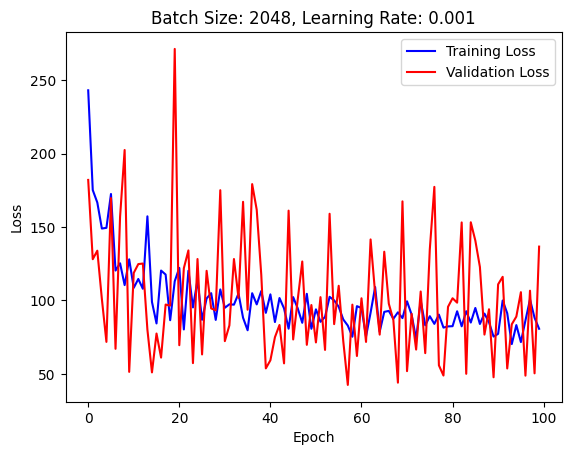

Epoch: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


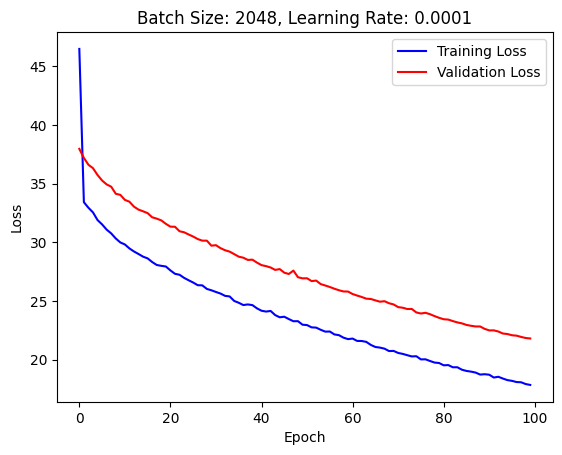

Epoch: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


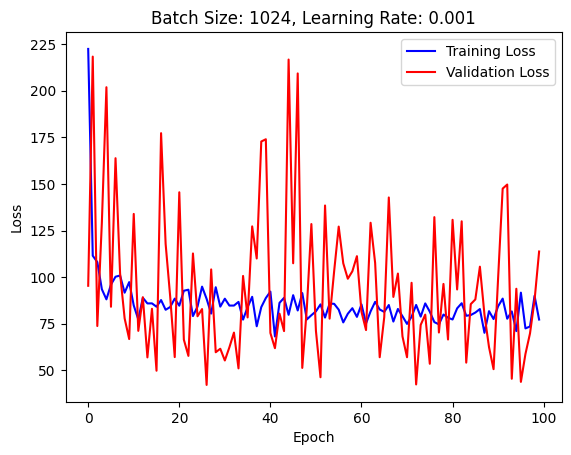

Epoch: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


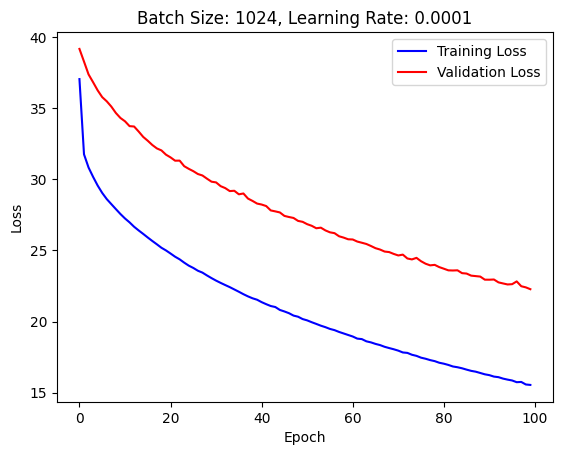

Epoch: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


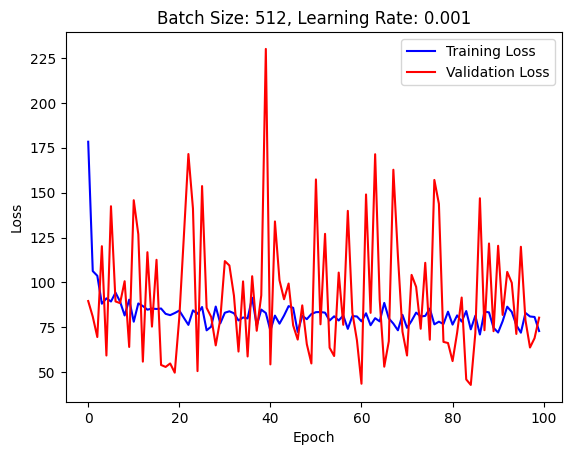

Epoch: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


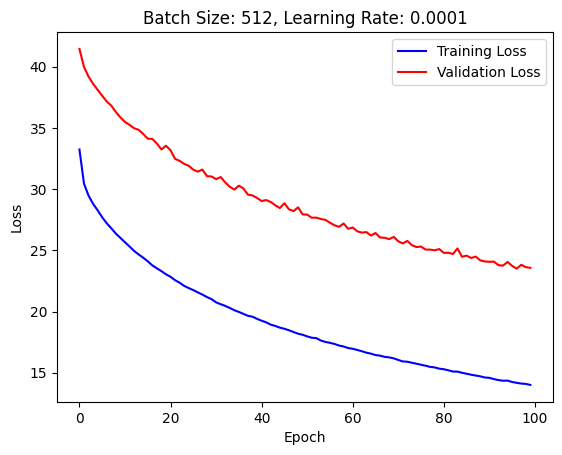

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Define possible batch sizes and learning rates
batch_sizes = [2048, 1024, 512]
learning_rates = [0.001, 0.0001]

# Create data loaders
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)

for batch_size in batch_sizes:
    for lr in learning_rates:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define optimizer for each configuration
        optimizer = optim.SGD(model.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1) #the scheduler changes alpha every 30 steps by a factor of 0.1

        train_losses = []
        val_losses = []

        for epoch in tqdm.tqdm(range(100), desc="Epoch"):
            # Training phase
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_losses.append(train_loss / len(train_loader))

            # Validation phase
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_losses.append(val_loss / len(val_loader))

        # Plot training and validation losses
        plt.figure()
        plt.plot(range(100), train_losses, label="Training Loss", color="blue")
        plt.plot(range(100), val_losses, label="Validation Loss", color="red")
        plt.title(f"Batch Size: {batch_size}, Learning Rate: {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

#### Results

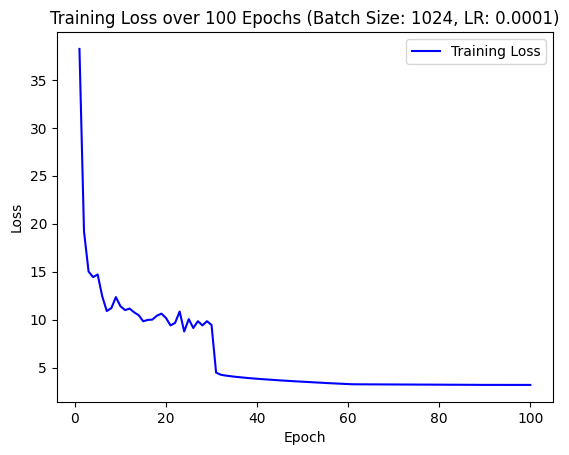

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

best_batch_size = 1024  # best found batch size
best_lr = 0.0001  # best found learning rate

# Create train and test data loaders using the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=best_batch_size, shuffle=False)

# Reinitialize the model and optimizer with the best learning rate
model = LinearClassifier(input_dim, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1) #the scheduler changes alpha every 30 steps by a factor of 0.1
criterion = torch.nn.CrossEntropyLoss()

# Training the model for 100 epochs
epochs = 100
train_losses = []

loop = tqdm.tqdm(range(epochs), desc="Epoch")
for epoch in loop:
    model.train()
    epoch_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    train_losses.append(epoch_loss / len(train_loader))
    loop.set_postfix_str("Loss: {}".format(epoch_loss / len(train_loader)))

# Testing phase: Evaluate on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Optional: Plot the training loss
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="blue")
plt.title(f"Training Loss over {epochs} Epochs (Batch Size: {best_batch_size}, LR: {best_lr})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


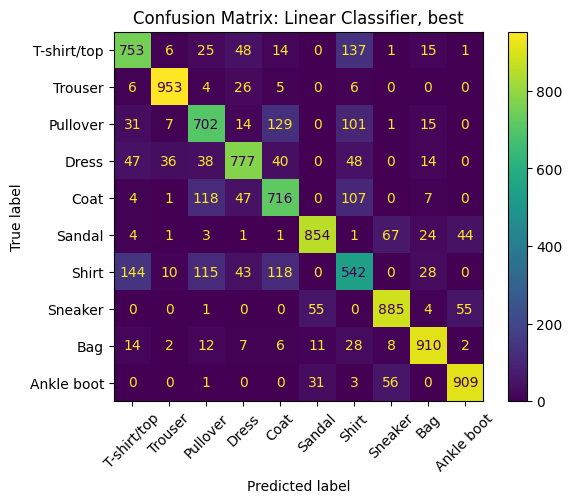


Linear Classifier, best
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1000
           1       0.94      0.95      0.95      1000
           2       0.69      0.70      0.70      1000
           3       0.81      0.78      0.79      1000
           4       0.70      0.72      0.71      1000
           5       0.90      0.85      0.88      1000
           6       0.56      0.54      0.55      1000
           7       0.87      0.89      0.88      1000
           8       0.89      0.91      0.90      1000
           9       0.90      0.91      0.90      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [ ]:
show_ConfusionMatrix(all_labels, all_preds, "Linear Classifier, best")
print('\nLinear Classifier, best')
print(classification_report(all_labels, all_preds,))

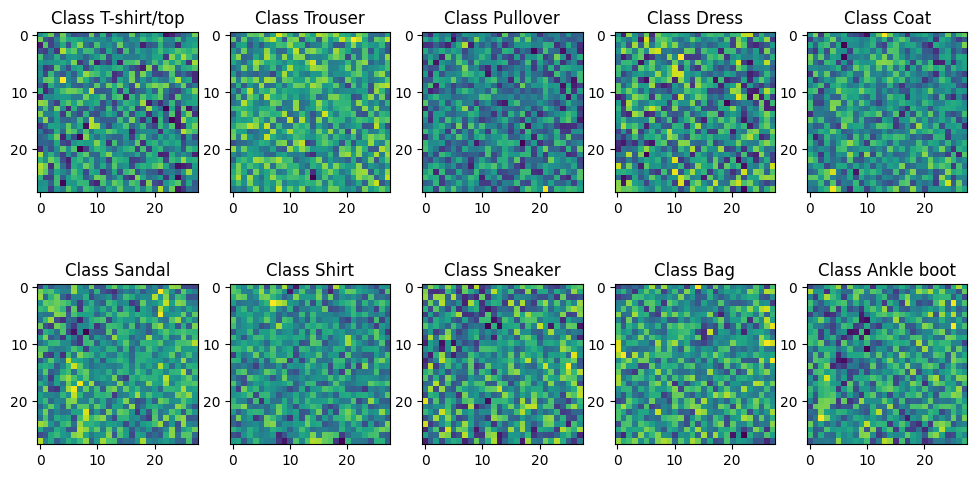

In [ ]:
weights = model.fc1.weight.data.cpu().numpy()
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(weights[i].reshape(28, 28), cmap='viridis')
    ax.set_title(f"Class {LABEL_MAP(i)}")
plt.show()

## Assignment 2B

---

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations and load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# Preprocess the data (flatten images)
train_images = train_data.data.view(-1, 28*28).float().to(device)
train_labels = train_data.targets.to(device)
test_images = test_data.data.view(-1, 28*28).float().to(device)
test_labels = test_data.targets.to(device)

# Split into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)


# Define the two-layer neural network with Xavier initialization
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

        # l2 regularization
        # self.dropout = nn.Dropout(p=0.5)

        # Apply Xavier initialization to weights
        nn.init.xavier_uniform_(self.hidden.weight)
        nn.init.xavier_uniform_(self.output.weight)

        # Initialize biases
        # nn.init.zeros_(self.hidden.bias)
        # nn.init.zeros_(self.output.bias)

    def forward(self, x):
        H = torch.relu(self.hidden(x))  # ReLU activation in hidden layer
        y_hat = torch.softmax(self.output(H), dim=1)  # Softmax for output layer
        return y_hat

# Model parameters
input_dim = 28 * 28  # 784
hidden_dim = 3      # hidden layer size
output_dim = 10       # 10 classes

# Initialize model, loss, and optimizer
model = TwoLayerNN(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()



Epoch: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s, Train Loss: 2.1660, Validation Loss: 2.1722]


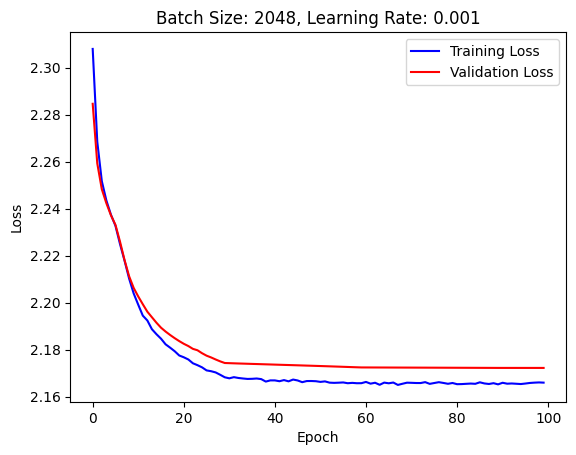

Epoch: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s, Train Loss: 2.1639, Validation Loss: 2.1703]


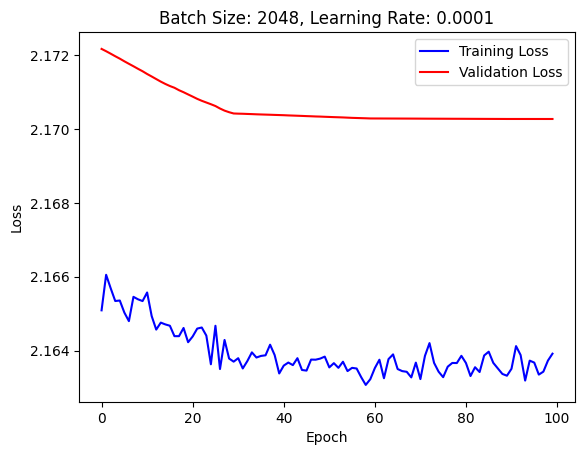

Epoch: 100%|██████████| 100/100 [01:01<00:00,  1.61it/s, Train Loss: 2.1357, Validation Loss: 2.1461]


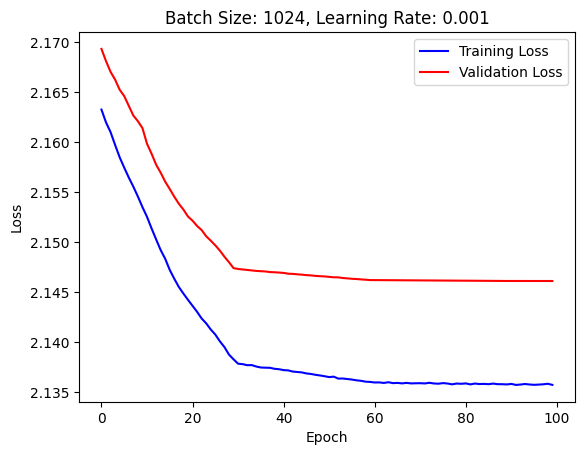

Epoch: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s, Train Loss: 2.1342, Validation Loss: 2.1448]


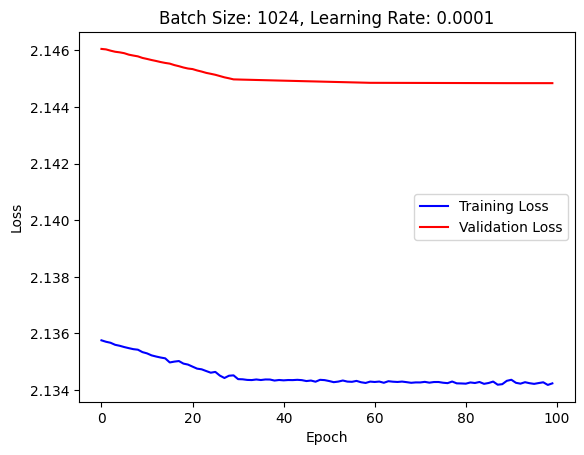

Epoch: 100%|██████████| 100/100 [01:01<00:00,  1.61it/s, Train Loss: 2.1166, Validation Loss: 2.1270]


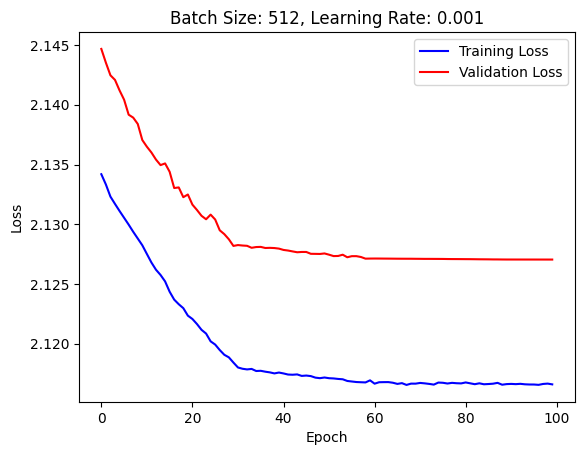

Epoch: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s, Train Loss: 2.1154, Validation Loss: 2.1260]


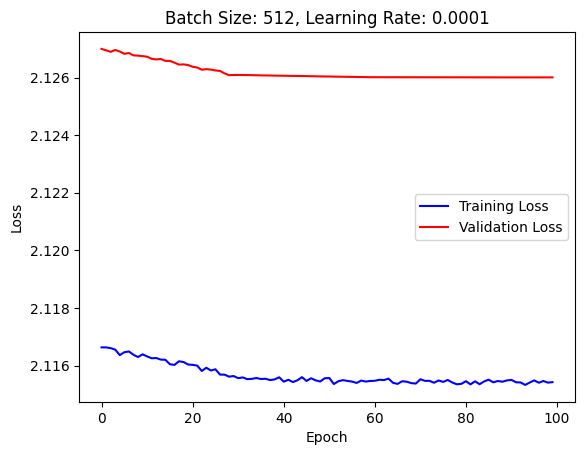

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Define possible batch sizes and learning rates
batch_sizes = [2048, 1024, 512]
learning_rates = [0.001, 0.0001]

# Create data loaders
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)

for batch_size in batch_sizes:
    for lr in learning_rates:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define optimizer for each configuration
        optimizer = optim.SGD(model.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1) #the scheduler changes alpha every 30 steps by a factor of 0.1

        train_losses = []
        val_losses = []

        loop = tqdm.tqdm(range(100), desc="Epoch")
        for epoch in loop:
            # Training phase
            model.train()
            train_loss = 0
            for images, labels in train_loader:
                #print("Labels shape:", labels.shape)
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            scheduler.step()

            train_losses.append(train_loss / len(train_loader))

            # Validation phase
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_losses.append(val_loss / len(val_loader))
            loop.set_postfix_str(f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

        # Plot training and validation losses
        plt.figure()
        plt.plot(range(100), train_losses, label="Training Loss", color="blue")
        plt.plot(range(100), val_losses, label="Validation Loss", color="red")
        plt.title(f"Batch Size: {batch_size}, Learning Rate: {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


In [ ]:
# #from the above we have found the best batch size to be 512 and learning rate to be 0.001
# # but we are forced to use 2048 and 0.001 due to question

# # Create DataLoaders
# batch_size = 512
# train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(TensorDataset(val_images, val_labels), batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=batch_size, shuffle=False)

# # Use Adam optimizer
# learning_rate = 0.001  #best lr
# # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# # scheduler = StepLR(optimizer, step_size=30, gamma=0.001)  #we had to tune this value several times to find the best result

# # test SGD
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=300, gamma=.5) #the scheduler changes alpha every 30 steps by a factor of 0.1

# # Training loop
# epochs = 100
# train_losses = []
# val_losses = []

# loop = tqdm.tqdm(range(epochs), desc="Epoch")
# for epoch in loop:
#     model.train()
#     running_train_loss = 0

#     for images, labels in train_loader:
#         optimizer.zero_grad()

#         # Forward pass
#         y_hat = model(images)

#         # Calculate loss
#         loss = criterion(y_hat, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         running_train_loss += loss.item()
#     scheduler.step()

#     train_losses.append(running_train_loss / len(train_loader))

#     # Validation phase
#     model.eval()
#     running_val_loss = 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             y_hat = model(images)
#             loss = criterion(y_hat, labels)
#             running_val_loss += loss.item()
#         scheduler.step()

#     val_losses.append(running_val_loss / len(val_loader))
#     loop.set_postfix_str(f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")


# # Plot the training and validation losses
# plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="blue")
# plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="red")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss")
# plt.legend()
# plt.show()

# Evaluate on test data
model.eval()
all_preds = []
all_labels = []
hidden_outputs = []

with torch.no_grad():
    for images, labels in test_loader:
        y_hat = model(images)

        # pleeeease
        hidden_outputs.extend(torch.relu(model.hidden(images)).cpu().numpy())

        _, preds = torch.max(y_hat, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



10000 10000 10000


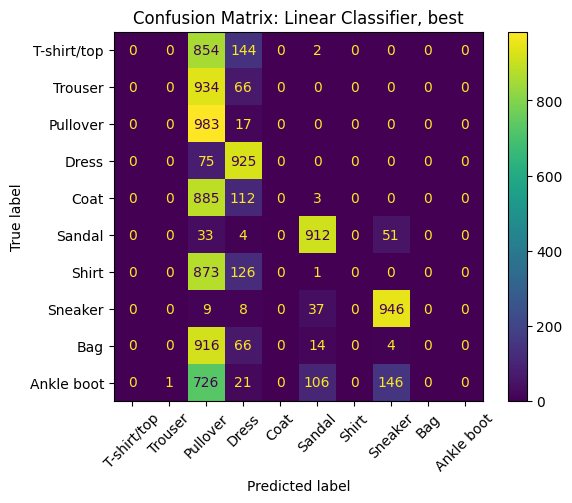


Linear Classifier, best
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.16      0.98      0.27      1000
           3       0.62      0.93      0.74      1000
           4       0.00      0.00      0.00      1000
           5       0.85      0.91      0.88      1000
           6       0.00      0.00      0.00      1000
           7       0.82      0.95      0.88      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.38     10000
   macro avg       0.25      0.38      0.28     10000
weighted avg       0.25      0.38      0.28     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(len(all_labels), len(all_preds), len(hidden_outputs))

show_ConfusionMatrix(all_labels, all_preds, "Linear Classifier, best")
print('\nLinear Classifier, best')
print(classification_report(all_labels, all_preds,))

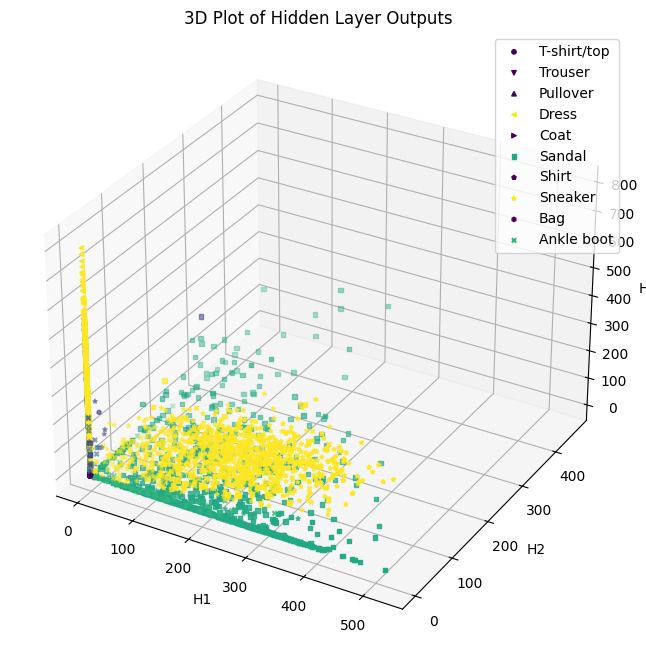

In [ ]:
# Plot Hidden Layer Outputs in 3D
hidden_outputs = np.array(hidden_outputs)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Different marker shapes and colors for ground truth and predicted class
colors = all_preds  # Predicted class as color
shapes = all_labels  # True class as shape
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'x']  # 10 marker styles

for cls in range(10):
    mask = np.array(shapes) == cls
    ax.scatter(hidden_outputs[mask, 0], hidden_outputs[mask, 1], hidden_outputs[mask, 2],
               c=np.array(colors)[mask], label=LABEL_MAP(cls), marker=markers[cls], s=10)

ax.set_xlabel("H1")
ax.set_ylabel("H2")
ax.set_zlabel("H3")
plt.legend()
plt.title("3D Plot of Hidden Layer Outputs")
plt.show()


## Assignment 2C

---

---

Will submit the derivative derivation seperately,

In [ ]:
import cupy as cp
class OneLayerNN:

    ########################         Configuration

    num_features: int
    num_classes: int
    num_neurons: int

    activation_type: str            # type of activation function to use, applied to the output of every layer
    regularization: int             # constant that determines how big the values of the weight matrices are allowed to be
    learning_rate: float

    ########################

    Wh: cp.array        # Weights for hidden layer
    Wo: cp.array        # Weights for output layer
    bh: cp.array        # Bias vector for hidden layer
    bo: cp.array        # Bias vector for output layer

    training_vectors: cp.array          # training data(images) and labels
    training_labels: cp.array
    validation_vectors: cp.array        # validation data(images) and labels
    validation_labels: cp.array

    testing_vectors: cp.array           # testing data(images) and labels
    testing_labels: cp.array


    def __init__(self, num_features: int, num_classes: int, num_neurons: int, activation_function_type: str = "none", weight_decay: int = 0, seed: int = 1337):

        if (num_features <= 0 or num_classes <= 0 or num_neurons <= 0 or weight_decay < 0):
            raise ValueError("Invalid Parameters")

        self.num_classes = num_classes
        self.num_features = num_features
        self.num_neurons = num_neurons

        self.activation_type = activation_function_type
        # we need deterministic randomness to debug, so we want the following property
        # if the model is trained with the same set of data, then it must produce the same initial random weights/bias,
        # same loss value after training, and same weights/bias values after training, GIVEN THE SEED WAS SAME.
        cp.random.seed(seed)
        self.Wh, self.Wo, self.bh, self.bo = self.init_weights_xavier()

    # ready!
    def init_weights_xavier(self) -> tuple:
        """Returns initialized weights and biases involved in the 1-Neuron Layer Classifier based on multinomial logistic regression.

        We are going to implement Xavier initialization to ensure a good starting matrix that allows us to converge to a good result quickly.
        """
        # fixed: we have
        initconst_Wh = cp.sqrt(6.0/(self.num_features + self.num_neurons))
        initconst_Wo = cp.sqrt(6.0/(self.num_neurons + self.num_classes))

        Wh = cp.random.uniform(low=-initconst_Wh, high=initconst_Wh, size=(self.num_features, self.num_neurons))
        Wo = cp.random.uniform(low=-initconst_Wh, high=initconst_Wh, size=(self.num_features, self.num_neurons))

        #self.bh = cp.random.randn(self.num_neurons) * 1e-3          # unclear, most people say setting bias to 0 is better
        #self.bo = cp.random.randn(self.num_classes) * 1e-3

        bh = cp.zeros((self.num_neurons,))
        bo = cp.zeros((self.num_classes,))

        return Wh, Wo, bh, bo

    # ready!
    def objective(self, y: cp.array, y_pred: cp.array) -> float:
        def cross_entropy_loss(self, y: cp.array, y_pred: cp.array) -> float:
            """ Calculate the cross-entropy loss. """
            # Clip the predictions to avoid log(0)
            epsilon = 1e-15
            y_pred = cp.clip(y_pred, epsilon, 1 - epsilon)

            return -cp.sum(y * cp.log(y_pred)) / y.shape[0]

        def weight_decay_loss() -> float:
            """ Calculate the loss based on the size of the values of the weight matrices. """
            if self.regularization == 0:
                return 0
            else:
                normWh = cp.linalg.norm(self.Wh, ord="fro")**2
                normWo = cp.linalg.norm(self.Wo, ord="fro")**2
                return self.regularization * (normWh + normWo)/2.0

        # from now on, we are trying to minimize objective
        # Objective = Loss + size of elements in Matrix
        return cross_entropy_loss(y, y_pred) + weight_decay_loss()

    # ready!
    def forward(self, X: cp.array) -> cp.array:
        """ Perform the forward pass.

        A forward propagation is to, given some input data X, use the currently obtained weights and biases to produce a classification vector. """

        def softmax(self, logits: cp.array) -> cp.array:
            """Applies the softmax transform onto an array. This should only ever be called onto a vector (size 1xN or Nx1).

            Each element of the array is exponentiated, and divided by the sum of all the exponentiated elements of the array.
            """

            # exp_logits = cp.exp(logits)
            # return exp_logits / cp.sum(exp_logits)
            # definition, so whats the problem? what if one of the elements is really large?
            # this causes an overflow

            exp_logits = cp.exp(logits - cp.max(logits)) # subtracting all elements by max causes the largest to be 0, and all others to be negative
                                                    # to be negative, and e^(large neg) == 0, so no more problems with overflow
            return exp_logits / cp.sum(exp_logits)

        def activation(vec: cp.array) -> cp.array:
            def sigmoid(vec: cp.array):
                return 1.0 / (1.0 + cp.exp(-vec))
            def tanh(vec: cp.array):
                return cp.tanh(vec)
            def reLU(vec: cp,array):
                return vec * (vec > 0)
            def none(vec: cp.array):
                return vec

            activation_functions = {
                "sigmoid": sigmoid,
                "tanh": tanh,
                "reLU": reLU,
                "none": none
            }
            selected = activation_functions.get(self.activation_type)
            if selected is None:
                raise ValueError(f"Invalid activation type: {self.activation_type}")

            return selected(vec)

        H = activation(cp.matmul(X, self.Wh) + self.bh)
        out = cp.matmul(H, self.Wo) + self.Wo       # apparently you should not apply activation on the output layer so softmax can be interpreted as probabilities correctly

        return softmax(out)

    # ready!
    def validate(self, X: cp.array, y: cp.array, batch_size: int) -> tuple:
        """Validate the current model weights and biases, returning a vector of predictions, (i.e what the model
        thinks is the correct classification for some vectors input data), and a loss value that describes how close the predictions
        were to the correct answer (y)

        """

        # check if X and y are numpy arrays, and convert if necessary
        # temporarily disabled while working on cuda-less machine
        # if not hasattr(X, 'get'):
        #     X = numpyarr_to_cupyarr(X)
        # if not hasattr(y, 'get'):
        #     y = numpyarr_to_cupyarr(y)

        loss_val = 0
        predictions = []

        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            y_pred = self.forward(X_batch)

            loss_val += self.objective(y_batch, y_pred)

            predictions.append(y_pred)

        loss_val /= X.shape[0]
        y_pred = cp.concatenate(predictions, axis=0)

        return y_pred, loss_val

    def train(self, num_epoch: int, learning_rate: float, batch_size: int):
        # let X be the matrix of input data/samples(many images)
        # let y be the classification vector for each input vector in X(one image)

        X = self.training_vectors
        y = self.training_labels

        num_samples = X.shape[0]
        loss = {
            "train": [],
            "val": []
        }

        for i in tqdm(range(num_epoch), desc="Epoch"):
            loss_epoch = 0            # loss for this current epoch.

            # loop for all mini
            loop = tqdm(range(0, num_samples, batch_size), leave=False)
            for j in loop:
                X_batch = X[j:j+batch_size]
                y_batch = y[j:j+batch_size]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Calculate loss
                loss_epoch += self.objective(y_batch, y_pred)    # loss per minibatch

                # Backward pass
                dW, db = self.backward(X_batch, y_batch, y_pred)

                # update
                self.update(dW, db, learning_rate)

            loss["train"].append(loss_epoch/num_samples)

            # training done, now validate
            loss_val, y_pred = self.validate(X, y, batch_size)
            loss["val"].append(loss_val)

        return None

    def update(self, dWh: cp.array, dbh: cp.array, dWo: cp.array, dbo: cp.array) -> tuple:
        """
        Update the weights and bias.
        :param dW: The weights gradients.         // dW is a MATRIX OF derivatives!!!! thats the only way you could possibly decrement W by dW
        :param db: The bias gradients.
        """
        self.Wh -= self.learning_rate * dWh
        self.Wo -= self.learning_rate * dWo
        self.bh -= self.learning_rate * dbh
        self.bo -= self.learning_rate * dbo

    def backward(X: cp.array, y: cp.array, y_pred: cp.array) -> tuple:
        """ Perform the backward pass.

        A backward pass, also called backpropagation, is to find the gradient of the neural network parameters. To be more specific,

        Let the objective function o(L,s) = L + s, where L is the cross-entropy loss and s is the weight-decay constraint

        Our goal is to minimize objective as much as possible, which happens for the Wh and Wo at which do/dWh == 0 and do/dWo == 0.

        Hence do/dWh(Wh, Wo) returns a matrix indicating the gradients at this point in the function space. Hence Wh - do/dWh will cause us to move
        in the direction where do/dWh will tend to 0. Same for dWo and db.
        """
        m = X.shape[0]
        #dW = (1 / m) * cp.dot(X.T, (y_pred - y))
        # dWh

        # #db = (1 / m) * cp.sum((y_pred - y), axis=0)
        # return dW, db